<ins>Logical Workflow PA Project</ins>

0. Call Data from SQL Server and save to local .pkl. Filter by TBM 1 and time span ('2022/02/01', '2022/04/01')
1. Join data for a complete dataset
2. Initial Filter (by Equipment ID: TBM 1 and remove Trial Recipes), key generation, cycle time generation and EDA
3. Left Merge Alarm mapping and Alarm hisroy on Created Key.
4. Alarm Discovery: Alarm to GT allocation: Calculate PAAP start and finish times if needed. Do NOT Filter alarms by Type e.g.  FF, CF and MC, assin name in#dexes. Link these alarm name indexes that are occurring for the same green tire at those times identified as PA. Create GT to Alarm Index Mapping.
5. One Hot encode Alarm Indexes before we carry out feature selction to see relevant alarms.
6. Feature selection: Initial Filter using statistical univariate filter methods. 
7. Feature selection: Narrow down using ML Models. Identify which steps are posing the issue (i.e. is it sidewall, inner liner, is it transport time etc.)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from matplotlib.pyplot import figure
import seaborn as sns

In [2]:
import matplotlib
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [4]:
ohe = pd.read_pickle("./pkl/alarm_ohe.pkl")

In [7]:
ohe

,Id,list_of_alarms,VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP,6,10,17,19,33,34,37,...,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018
1,11141586,"[327, 926]",3.987,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11141590,[927],3.993,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11141591,[926],3.898,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,11141640,"[522, 926]",3.994,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,11141641,"[242, 522, 926]",3.893,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110212,12464393,[242],3.910,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
110213,12464394,[242],3.911,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
110214,12464395,[926],3.907,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
110215,12464396,[926],3.913,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Filter method is less accurate. It is great while doing EDA, it can also be used for checking multi co-linearity in data. Use this first to get to manageable number of alarms (~60). 

Then use Wrapper and Embedded methods to give more accurate results but as they are computationally expensive, these method are suited when we have fewerfeatures (~20).

## Filter Method:
Filter and take only the subset of the relevant features. The filtering here is done using correlation matrix and it is most commonly done using Pearson correlation. Have also tried Kendall Tau correlation coefficient & Spearman rank correlation and taken the common ones from the top 80 alarms. 

In [8]:
#Loading the dataset columns
X = ohe.drop(["VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP", 'Id'],1)   #Feature Matrix
y = ohe["VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP"]          #Target Variable
ohe.head()

<ipython-input-8-486b4cf30a58>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = ohe.drop(["VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP", 'Id'],1)   #Feature Matrix


,Id,list_of_alarms,VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP,6,10,17,19,33,34,37,...,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018
1,11141586,"[327, 926]",3.987,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11141590,[927],3.993,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11141591,[926],3.898,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,11141640,"[522, 926]",3.994,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,11141641,"[242, 522, 926]",3.893,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
#Using Pearson Correlation
cor = ohe.corr(method='pearson')

In [10]:
#Correlation with output variable
cor_target = abs(cor["VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP"])
#Selecting highly correlated features
relevant_features = cor_target

num = 50
print(f"Top {num} Alarms correlated to PA Cycle Time")
top50pear = cor_target.sort_values(ascending=False).head(num)
cor_target.sort_values(ascending=False).head(num)

Top 50 Alarms correlated to PA Cycle Time


VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP    1.000000
968                                  0.403895
681                                  0.395126
1006                                 0.387630
870                                  0.334983
692                                  0.322548
1005                                 0.287147
927                                  0.250801
999                                  0.238281
524                                  0.234564
269                                  0.232122
220                                  0.228513
529                                  0.216253
931                                  0.212662
683                                  0.209661
951                                  0.208417
186                                  0.190655
653                                  0.186531
855                                  0.179638
527                                  0.178921
113                                  0.168518
965                               

In [11]:
#Using Kendall Tau correlation coefficient
cor2 = ohe.corr(method='kendall')

c:\Users\shav.vimelindiran\Anaconda3\envs\ml\lib\site-packages\scipy\stats\stats.py:4812: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
c:\Users\shav.vimelindiran\Anaconda3\envs\ml\lib\site-packages\scipy\stats\stats.py:4814: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(var) / np.sqrt(2)))


In [12]:
#Using Spearman rank correlation
cor3 = ohe.corr(method='spearman')

In [13]:
cor.to_pickle("./pkl/cor.pkl")
cor2.to_pickle("./pkl/cor2.pkl")
cor3.to_pickle("./pkl/cor3.pkl")

In [3]:
cor = pd.read_pickle("./pkl/cor.pkl")
cor2 = pd.read_pickle("./pkl/cor2.pkl")
cor3 = pd.read_pickle("./pkl/cor3.pkl")

In [15]:
#Correlation with output variable
cor_target2 = abs(cor2["VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP"])
#Selecting highly correlated features
relevant_features = cor_target2

num = 50
print(f"Top {num} Alarms correlated to PA Cycle Time")
top50ken = cor_target2.sort_values(ascending=False).head(num)

Top 50 Alarms correlated to PA Cycle Time


In [16]:
#Correlation with output variable
cor_target3 = abs(cor3["VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP"])
#Selecting highly correlated features
relevant_features = cor_target3

num = 50
print(f"Top {num} Alarms correlated to PA Cycle Time")
top50spear = cor_target3.sort_values(ascending=False).head(num)

Top 50 Alarms correlated to PA Cycle Time


Intersecting Alarms from 3 Methods of correlation

In [23]:
def intersect(num, cor, cor2, cor3):
    #Correlations with output variable
    cor_target = abs(cor["VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP"])
    cor_target2 = abs(cor2["VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP"])
    cor_target3 = abs(cor3["VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP"])

    #collect tom n
    top_n_pear = cor_target.sort_values(ascending=False).head(num)
    top_n_ken = cor_target2.sort_values(ascending=False).head(num)
    top_n_spear = cor_target3.sort_values(ascending=False).head(num)

    # Convert to lists 
    list1 = list(top_n_pear.index)
    list2 = list(top_n_ken.index)
    list3 = list(top_n_spear.index)

    return set(list1) & set(list2) & set(list3)

In [18]:
def numintersect(num, cor, cor2, cor3):
    #Correlations with output variable
    cor_target = abs(cor["VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP"])
    cor_target2 = abs(cor2["VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP"])
    cor_target3 = abs(cor3["VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP"])

    #collect tom n
    top_n_pear = cor_target.sort_values(ascending=False).head(num)
    top_n_ken = cor_target2.sort_values(ascending=False).head(num)
    top_n_spear = cor_target3.sort_values(ascending=False).head(num)

    # Convert to lists 
    list1 = list(top_n_pear.index)
    list2 = list(top_n_ken.index)
    list3 = list(top_n_spear.index)

    return len(set(list1) & set(list2) & set(list3))   

In [19]:
numintersect(50, cor, cor2, cor3)

29

In [20]:
topn = list(range(1,312))
intersect = []

for i in topn:
    intersect.append(numintersect(i, cor, cor2, cor3))

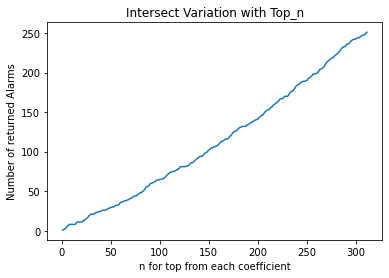

In [21]:
plt.plot(topn,intersect)
plt.title('Intersect Variation with Top_n')
plt.xlabel('n for top from each coefficient')
plt.ylabel('Number of returned Alarms')
plt.show()

In [24]:
intersect_alarms = intersect(50, cor, cor2, cor3)

In [26]:
list_int = list(intersect_alarms)
list_int.remove('VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP')
list_int

[524,
 269,
 529,
 531,
 532,
 915,
 918,
 920,
 925,
 927,
 929,
 931,
 806,
 681,
 683,
 692,
 951,
 184,
 697,
 965,
 968,
 855,
 220,
 870,
 999,
 1005,
 1006,
 113]

 One of the assumptions of linear regression is that the independent variables need to be uncorrelated with each other. If these variables are correlated with each other, then we need to keep only one of them and drop the rest. So let us check the correlation of selected features with each other. 

In [ ]:
# print(ohe[[192,16]].corr())
# print(ohe[[23, 89]].corr())

Or we can use a plot to visualise this.

In [6]:
list_int = [524, 269, 529, 531, 532, 915, 918, 920, 925, 927, 929, 931, 806, 681, 683, 692, 951, 184, 697, 965, 968, 855, 220, 870, 999, 1005, 1006, 113]
len(list_int)

28

In [8]:
ohe[list_int]

,524,269,529,531,532,915,918,920,925,927,...,697,965,968,855,220,870,999,1005,1006,113
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110212,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
110213,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
110214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
110215,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
shortened_ohe = ohe[list_int]
shortened_ohe['Id'] = ohe['Id']
shortened_ohe['VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP'] = ohe['VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP']
shortened_ohe

<ipython-input-28-23c78c058ddf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shortened_ohe['Id'] = ohe['Id']
<ipython-input-28-23c78c058ddf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shortened_ohe['VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP'] = ohe['VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP']


,524,269,529,531,532,915,918,920,925,927,...,968,855,220,870,999,1005,1006,113,Id,VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11141586,3.987
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,11141590,3.993
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11141591,3.898
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11141640,3.994
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11141641,3.893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110212,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,12464393,3.910
110213,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,12464394,3.911
110214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,12464395,3.907
110215,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,12464396,3.913


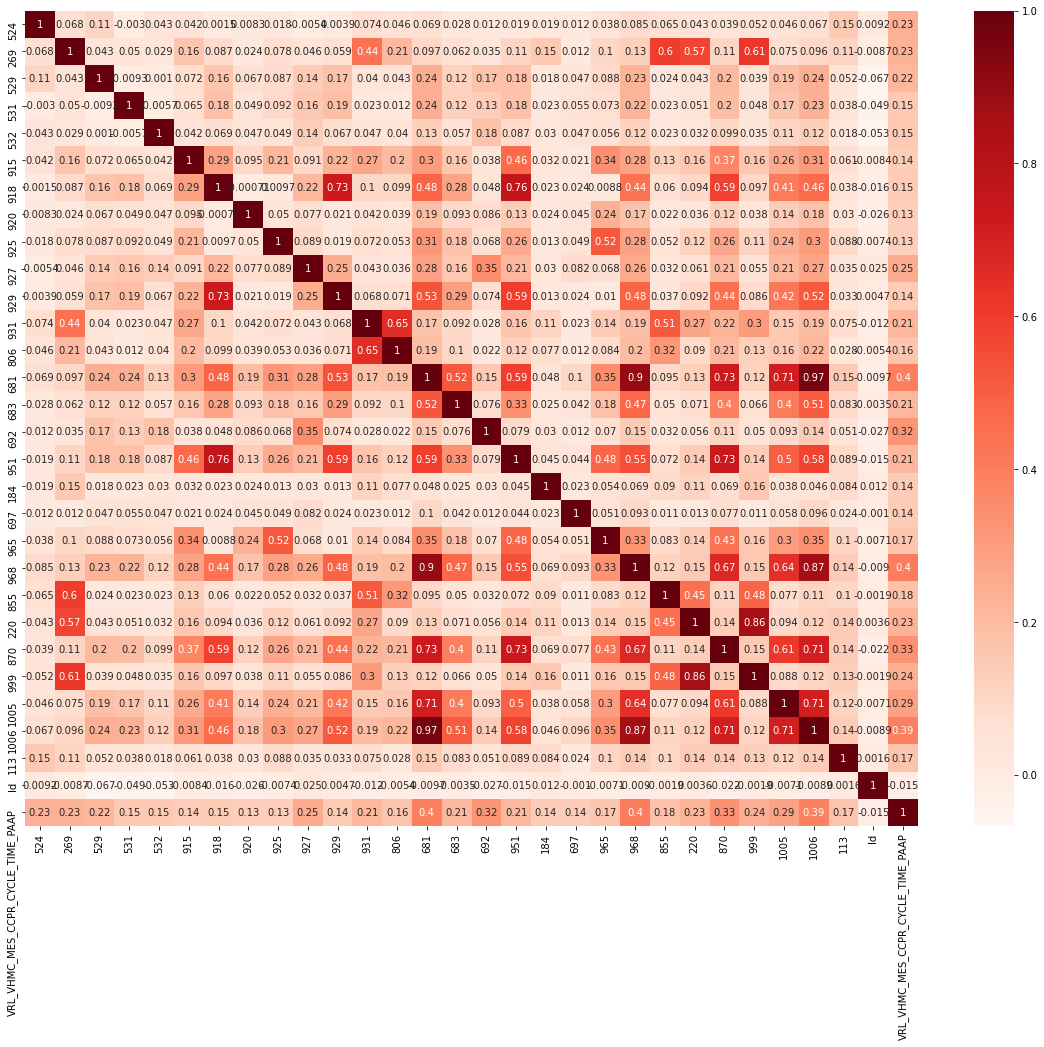

In [29]:
#Using Pearson Correlation
plt.figure(figsize=(20,15))
cor = shortened_ohe.corr(method='pearson')
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

681:1006 

for just one example are highly correlated with each other (0.97 is close to 1) means we would only need to keep one variable and drop the other. 

These are univariate test - meaning it does not consider multiple variables together and their possible interactions. 

In [92]:
# list_int.remove(56)

In [30]:
list_int

[524,
 269,
 529,
 531,
 532,
 915,
 918,
 920,
 925,
 927,
 929,
 931,
 806,
 681,
 683,
 692,
 951,
 184,
 697,
 965,
 968,
 855,
 220,
 870,
 999,
 1005,
 1006,
 113]

In [31]:
list_int =[524, 269, 529, 531, 532, 915, 918, 920, 925, 927, 929, 931, 806, 681, 683, 692, 951, 184, 697, 965, 968, 855, 220, 870, 999, 1005, 1006, 113]